This notebook explores how to calculate the area within the zero isotherm - that is, the area of the Cold Intermediate Layer

This notebook attempts to refine the calculation using the climatolgoy.

In [1]:
import geopy.distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import shapely
from shapely.geometry.polygon import Polygon
from shapely.geometry import LineString

%matplotlib inline

# Load data

In [2]:
#coordinates of seal island transect
stations = pd.read_table('sealisland.txt', delimiter=' ')
numstations=stations.shape[0]
# distance along transect in km
distance = [geopy.distance.distance((stations.iloc[0]['LAT'], stations.iloc[0]['LON']),
                                    (stations.iloc[i]['LAT'], stations.iloc[i]['LON'])).km for i in range(numstations)]

In [3]:
# Read GLORYS data along SealIsland - I already saved in a csv
d = pd.read_csv('SealIsland_JulyClimatology_mercatorglorys12v1_gl12_mean_07_199301-201812.csv')

In [4]:
# Create arrays
temp = d['Temperature [degrees_C]'].values
depths = d['Depth [m]'].values
size=len(temp)
# Reshape data
numdepths = int(size/numstations)
temp = temp.reshape((numstations, numdepths ))
temp = np.ma.masked_invalid(temp)
depths = depths.reshape((numstations, numdepths))
_, distance = np.meshgrid(depths[0, :], distance)
mask = temp.mask
mask = mask*np.ones(mask.shape)

# Plotting

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """


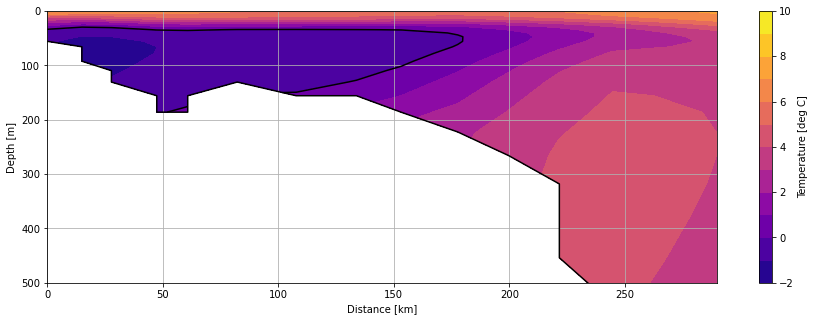

In [5]:
#Quick plot
fig, ax = plt.subplots(1,1,figsize=(15,5))
mesh = ax.contourf(distance, depths, temp, cmap='plasma',levels=np.arange(-2, 11,1))
contour = ax.contour(distance, depths, temp, [0,], colors='k')
cmask = ax.contour(distance, depths, mask, [1,], colors='k')
cbar = plt.colorbar(mesh,ax=ax)
cbar.set_label('Temperature [deg C]')
ax.set_ylim([500,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Distance [km]')
ax.grid()

# Area wth polygons shaped by zero contour
This method challenging to reproduce robustly or all possible contour configurations...

Here is my approach
* Firgure out where the zero contour intersects the ground
* Use a combination of the "ground" contours and the zero contours define a polygon
* Calculate area of the polygon

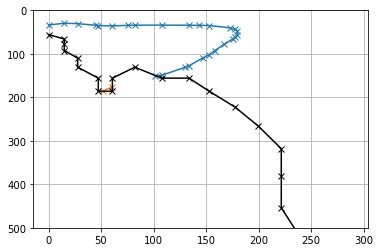

In [6]:
# Plot vertices of the zero contours 
# Note: the objects contour/cmask were defined above with the ax.contour(...) calls
fig,ax = plt.subplots(1,1)
for z in contour.collections:
    v = z.get_paths()
    # Loop through all zero contours
    for p in v:
        x = p.vertices[:,0]
        y = p.vertices[:,1]
        ax.plot(x,y,'-x')
ax.set_ylim([500,0])
# Plot vertices of the cmask
for z in cmask.collections:
    v = z.get_paths()
    for p in v:
        xmask = p.vertices[:,0]
        ymask = p.vertices[:,1]
        ax.plot(xmask,ymask,'kx-',)
ax.set_ylim([500,0])
ax.grid()
ymask=ymask/1000 #convert to km

Ok, I will attempt the following algorithm:

1. Find all zero contours
2. Idenitfy zero contours that aren't closed
  a. identify where they intersect bottom.
  b. construct segmments to build polyons
3. Sum area of each polygon...

In [7]:
thres=1e-9 # Threshold for idenitifying a closed polygon
closed_polys = []
open_polys = []
for z in contour.collections:
    v = z.get_paths()
    # Plot vertices of the zero contour
    for p in v:
        x = p.vertices[:,0]
        y = p.vertices[:,1]
        y=y/1000 # convert to km
        print(x[0], x[-1])
        print(y[0], y[-1])
        if np.abs(x[0] - x[-1])<thres  and np.abs(y[0] == y[-1]) < thres:
            poly = Polygon((xc,yc) for xc,yc in zip(x,y))
            closed_polys.append(poly)
        else:
            open_polys.append((x,y))

0.0 101.77614205493937
0.03363322558899175 0.15000376695115397
60.77376732816852 51.827799733860644
0.17575417318592648 0.18612559509277343


In [8]:
# For each open poly, identify where it intersects the cmask poly. There is a special case if the first coordinate is x=0.
buffer=1e-6  #distance buffer for checking if line segments intersect
mask_segments={}
for count,p in enumerate(open_polys):
    xp=p[0]
    yp=p[1]
    mask_segments[count]=[]
    if xp[0] == 0:
        # Create intersection between ground and last line segment
        ls = LineString([(xp[-2], yp[-2]), (xp[-1], yp[-1])])
        for n in range(len(xmask)-1):
            gs = LineString([(xmask[n], ymask[n]), (xmask[n+1], ymask[n+1])])
            if ls.buffer(10e-6).intersects(gs):
                mask_segments[count].append(n)
    else:
        # Special case if open_poly is only two points
        if len(xp) == 2:
            ls = LineString([(xp[0], yp[0]), (xp[1], yp[1])])
            # Find both potentiall two intersection points
            for n in range(len(xmask)-1):
                gs = LineString([(xmask[n], ymask[n]), (xmask[n+1], ymask[n+1])])
                if ls.buffer(buffer).intersects(gs):
                    mask_segments[count].append(n)
        else:
            # First line segment
            ls = LineString([(xp[-1], yp[-1]), (xp[-2], yp[-2])])
            for n in range(len(xmask)-1):
                gs = LineString([(xmask[n], ymask[n]), (xmask[n+1], ymask[n+1])])
                if ls.buffer(buffer).intersects(gs):
                    mask_segments[count].append(n)
            # LAst line segment
            ls = LineString([(xp[-1], yp[-1]), (xp[-2], yp[-2])])
            for n in range(len(xmask)-1):
                gs = LineString([(xmask[n], ymask[n]), (xmask[n+1], ymask[n+1])])
                if ls.buffer(buffer).intersects(gs):
                    mask_segments[count].append(n)

In [9]:
mask_segments

{0: [17], 1: [19, 20]}

In [10]:
# Constrct the polygon
poly_points = []
for count, p in enumerate(open_polys):
    ns = mask_segments[count]
    xp=p[0]
    yp=p[1]
    if len(ns) <2:
        lastns=ns[0]
        poly_points.extend([(x,y)] for x, y in zip(xp, yp))
    else:
        for n in ns[0:-1]:
            poly_points.extend([(xmask[i], ymask[i])] for i in range(lastns+1,n+1))
            poly_points.extend([(x,y)] for x, y in zip(xp, yp))
            lastns=n
poly_points.extend([(xmask[i], ymask[i])] for i in range(ns[-1]+1,len(ymask)))

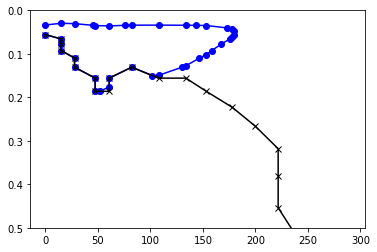

In [11]:
fig, ax=plt.subplots(1,1)
ys = [p[0][1] for p in poly_points]
xs = [p[0][0] for p in poly_points]
ax.plot(xs, ys, 'ob-')
ax.set_ylim([0.5,0])
ax.plot(xmask,ymask,'kx-')

In [12]:
# Area
poly = Polygon((p[0][0], p[0][1]) for p in poly_points )
poly.area

15.924760815893013

(0.5, 0.0)

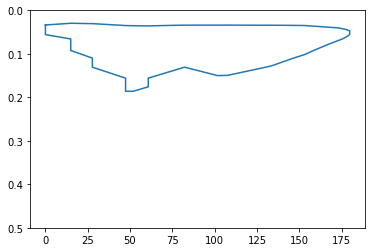

In [13]:
fig,ax=plt.subplots(1,1)
ax.plot(*poly.exterior.xy)
ax.set_ylim([0.5,0])

## Quick check of algorithm with PSY4 2020

In [14]:
# # Read PSY4 data along SealIsland - I already saved in a csv
d = pd.read_csv('SealIsland_2020_global-analysis-forecast-phy-001-024.csv')

In [15]:
#coordinates of seal island transect
stations = pd.read_table('sealisland.txt', delimiter=' ')
numstations=stations.shape[0]
# distance along transect in km
distance = [geopy.distance.distance((stations.iloc[0]['LAT'], stations.iloc[0]['LON']),
                                    (stations.iloc[i]['LAT'], stations.iloc[i]['LON'])).km for i in range(numstations)]
# Create arrays
temp = d['Temperature [degrees_C]'].values
depths = d['Depth [m]'].values
size=len(temp)
# Reshape data
numdepths = int(size/numstations)
temp = temp.reshape((numstations, numdepths ))
temp = np.ma.masked_invalid(temp)
depths = depths.reshape((numstations, numdepths))
_, distance = np.meshgrid(depths[0, :], distance)
mask = temp.mask
mask = mask*np.ones(mask.shape)

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """


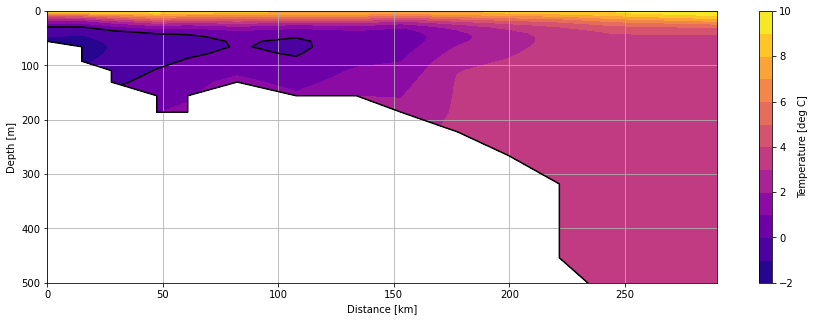

In [16]:
#Quick plot
fig, ax = plt.subplots(1,1,figsize=(15,5))
mesh = ax.contourf(distance, depths, temp, cmap='plasma',levels=np.arange(-2, 11,1))
contour = ax.contour(distance, depths, temp, [0,], colors='k')
cmask = ax.contour(distance, depths, mask, [1,], colors='k')
cbar = plt.colorbar(mesh,ax=ax)
cbar.set_label('Temperature [deg C]')
ax.set_ylim([500,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Distance [km]')
ax.grid()

In [17]:
thres=1e-9 # Threshold for idenitifying a closed polygon
closed_polys = []
open_polys = []
for z in contour.collections:
    v = z.get_paths()
    # Plot vertices of the zero contour
    for p in v:
        x = p.vertices[:,0]
        y = p.vertices[:,1]
        y=y/1000 # convert to km
        if np.abs(x[0] - x[-1])<thres  and np.abs(y[0] == y[-1]) < thres:
            poly = Polygon((xc,yc) for xc,yc in zip(x,y))
            closed_polys.append(poly)
        else:
            open_polys.append((x,y))

In [18]:
# For each open poly, identify where it intersects the cmask poly. There is a special case if the first coordinate is x=0.
buffer=1e-6  #distance buffer for checking if line segments intersect
mask_segments={}
for count,p in enumerate(open_polys):
    xp=p[0]
    yp=p[1]
    mask_segments[count]=[]
    if xp[0] == 0:
        # Create intersection between ground and last line segment
        ls = LineString([(xp[-2], yp[-2]), (xp[-1], yp[-1])])
        for n in range(len(xmask)-1):
            gs = LineString([(xmask[n], ymask[n]), (xmask[n+1], ymask[n+1])])
            if ls.buffer(10e-6).intersects(gs):
                mask_segments[count].append(n)
    else:
        # Special case if open_poly is only two points
        if len(xp) == 2:
            ls = LineString([(xp[0], yp[0]), (xp[1], yp[1])])
            # Find both potentiall two intersection points
            for n in range(len(xmask)-1):
                gs = LineString([(xmask[n], ymask[n]), (xmask[n+1], ymask[n+1])])
                if ls.buffer(buffer).intersects(gs):
                    mask_segments[count].append(n)
        else:
            # First line segment
            ls = LineString([(xp[-1], yp[-1]), (xp[-2], yp[-2])])
            for n in range(len(xmask)-1):
                gs = LineString([(xmask[n], ymask[n]), (xmask[n+1], ymask[n+1])])
                if ls.buffer(buffer).intersects(gs):
                    mask_segments[count].append(n)
            # LAst line segment
            ls = LineString([(xp[-1], yp[-1]), (xp[-2], yp[-2])])
            for n in range(len(xmask)-1):
                gs = LineString([(xmask[n], ymask[n]), (xmask[n+1], ymask[n+1])])
                if ls.buffer(buffer).intersects(gs):
                    mask_segments[count].append(n)

In [19]:
mask_segments

{0: [22]}

In [20]:
# Constrct the polygon
poly_points = []
for count, p in enumerate(open_polys):
    ns = mask_segments[count]
    xp=p[0]
    yp=p[1]
    if len(ns) <2:
        lastns=ns[0]
        poly_points.extend([(x,y)] for x, y in zip(xp, yp))
    else:
        for n in ns[0:-1]:
            poly_points.extend([(xmask[i], ymask[i])] for i in range(lastns+1,n+1))
            poly_points.extend([(x,y)] for x, y in zip(xp, yp))
            lastns=n
poly_points.extend([(xmask[i], ymask[i])] for i in range(ns[-1]+1,len(ymask)))

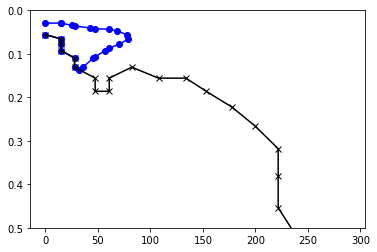

In [21]:
fig, ax=plt.subplots(1,1)
ys = [p[0][1] for p in poly_points]
xs = [p[0][0] for p in poly_points]
ax.plot(xs, ys, 'ob-')
ax.set_ylim([0.5,0])
ax.plot(xmask,ymask,'kx-')

In [22]:
# Area
poly = Polygon((p[0][0], p[0][1]) for p in poly_points )
closed_area = np.sum([p.area for p in closed_polys])
open_area = poly.area
print(closed_area + open_area)

4.807365629409965


(0.5, 0.0)

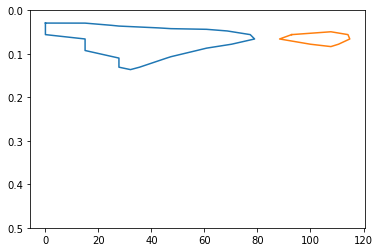

In [23]:
fig,ax=plt.subplots(1,1)
ax.plot(*poly.exterior.xy)
for p in closed_polys:
    ax.plot(*p.exterior.xy)
ax.set_ylim([0.5,0])

# Summary
* This method uses polygons to calculate the area of the cold intermediate layer. It looks for interseactions between the zero temperature contours and the ground.
* This method will likely fail if contours cross the surface because that case is not considered. Or if the CIL has a warm polygon in the interior.
* Again, let's check on how the observations are calculated.